# Наивный байесовский классификатор

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display
from sklearn.datasets import load_iris

from sklearn.pipeline import make_pipeline, Pipeline

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import RobustScaler, Normalizer

from sklearn.model_selection import train_test_split, cross_val_score  
from sklearn.model_selection import GridSearchCV, KFold, StratifiedShuffleSplit

from sklearn.naive_bayes import GaussianNB 
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier 

from sklearn.metrics import classification_report

import sklearn
print(sklearn.__version__)


1.1.2


# О смысле вероятности

Несмотря на то что теория вероятностей является вполне сформировавшейся и прочно обоснованной математической дисциплиной (вспомним, «сигма алгебра над пространством исходов»), существуют и другие интерпретации смысла термина «вероятность».

С байесовской точки зрения вероятность – это мера, которая определяет в числовом выражении уровень неопределенности высказывания.

С учетом этого определения вероятности абсолютно допустимо и даже естественно задать вопрос о вероятности существования жизни на Марсе или о вероятности того, что 22 июня 1812 года в Москве был солнечный день. 

Но при этом следует отметить, например, что жизнь на Марсе либо существует, либо не существует, то есть итоговый результат бинарный, это тип вопроса с ответом да-нет. Но, учитывая то, что мы не уверены в самом факте существования жизни на Марсе, разумным образом действий является попытка определить, насколько вероятна жизнь на Марсе.  

Если у нас нет информации о задаче, то вполне разумно утверждать, что любое возможное событие одинаково вероятно (правдоподобно), а с формальной точки зрения это равносильно предположению об одинаковой вероятности наступления любого возможного события. При отсутствии информации неопределенность максимальна. Но если нам известно, что наступление каких-либо событий более правдоподобно, то это можно формально представить предположением о более высокой вероятности наступления этих событий и более низкой вероятности для прочих событий. 

Отметим, что когда мы говорим о событиях в контексте статистики, то не ограничиваемся «событиями, которые могут произойти». 

Событие – это любое из возможных значений (или набора значений), которые может принимать некоторая переменная, например событие, соответствующее утверждению, что вам меньше 30 лет или количество велосипедов, проданных в прошлом году в Москве более 50 000 штук. 

Концепция байесовской вероятности очень связана с понятиями логики. С учетом байесовского определения вероятности определенность является всего лишь особым случаем: истинному утверждению соответствует вероятность 1, а ложному – вероятность 0.  

Присвоить значение вероятности 1 утверждению «жизнь на Марсе существует» можно было бы только после получения убедительных данных о том, что какие-то объекты развиваются и воспроизводятся, а также выполняют другие действия, которые мы считаем присущими живым организмам. Но следует также отметить, что присваивание значения вероятности 0 сложнее, потому что мы всегда можем считать, что некоторые области Марса остаются неисследованными, или что мы совершили ошибки в некотором эксперименте, либо какие-то другие причины могли привести к ложному выводу об отсутствии жизни на Марсе, хотя этот факт не доказан.

Здесь уместно применение правила Кромвеля (в честь Оливера Кромвеля и его фразы "*Заклинаю вас всеми страстями христовыми — задумайтесь на минуту о том, что можете ошибаться*", введено статистиком Деннисом Линдли), гласящего, что необходимо избегать применения априорных (т.е. заранее известных вероятностей полученное до проведения опыта и независимое от него) вероятностей 0 (событие не произойдет) или 1 (событие произойдет), за исключением логически истинных или ложных утверждений, например 2+2= 4 или 5.

**Примечание:** ***априорная вероятность*** или ***безусловная вероятность***, связанная с некоторым случайным событием, представляет собой степень уверенности в том, что данное событие произошло, в отсутствие любой другой информации, связанной с этим событием

Если обобщить все вышесказанное, то использование вероятности для описания неопределенности модели не обязательно связано с дискуссиями о том, является ли природа детерминированной (определенной) или случайной на самом базовом, фундаментальном уровне, кроме того, не связано и с субъективными личными верованиями. Это чисто методологический подход к моделированию неопределенности. Мы считаем большинство явлений трудными для глубокого понимания, потому что в основном имеем дело с неполными и/или зашумленными (загрязненными) данными. Вследствие этого мы используем методику моделирования, которая явно принимает во внимание неизбежную неопределенность.

## Базовое определение - условная вероятность

Вероятности – это числа в интервале [0,1], то есть числа между 0 и 1, включая оба граничных значения. 

Вероятности подчиняются нескольким правилам, одно из них правило умножения.

$$p(A,B) = p (A|B)p(B),$$  

где вероятность $A$ и $B$ равна вероятности $A$ при условии $B$, умноженной на вероятность $B$. Выражение $p(A,B)$ представляет совместную вероятность $A$ и $B$. Выражение $p(A|B)$ используется для обозначения условной вероятности. Это название указывает на то, что вероятность $A$ обусловлена знанием $B$ и зависит от него.

Например, вероятность того, что на улице солнечно, отличается от вероятности того, что на улице солнечно, если мы знаем (или предполагаем), что идет дождь (привет, грибной дождик).

Условная вероятность может быть больше, меньше или равна безусловной вероятности: 
- если знание $B$ не дает нам информацию об $A$, то $p(A|B) = p(A)$. Это выражение будет истинным, только если $A$ и $B$ независимы друг от друга;
- с другой стороны, если знание $B$ дает нам полезную информацию об $A$, то условная вероятность может быть больше или меньше априорной (безусловной) вероятности в зависимости от того, делает ли знание $B$ более или менее возможным $A$.

Приведем простой пример, так любимый в теории вероятностей - игральный кубик.

Какова вероятность выпадения числа 3 при броске кости $p(грань = 3)$? Она равна 1/6, так как каждое из шести чисел имеет одинаковый шанс для обычной шестигранной кости. 

А чему равна вероятность выпадения числа 3, при условии что мы получаем нечетное число, то есть $p(грань=3|грань = нечетная)$? Вероятность равна 1/3, поскольку если мы знаем, что получаем нечетное число, то возможно выпадение только чисел $\{1, 3, 5\}$, и каждое из этих чисел имеет равные шансы.

Наконец, какова вероятность p(грань=3|грань=четная)? Она равна 0, так как если известно, что выпадает четное число, то возможны лишь варианты $\{2, 4, 6\}$, следовательно, появление числа 3 невозможно.

Из этого простого примера можно видеть, что при назначении условий для исследуемых данных мы действительно изменяем вероятность наступления событий, а вместе с тем и присущую им неопределенность. 

Условные вероятности можно назвать "фундаментом" статистики независимо от того, какая задача поставлена перед нами: бросание игральных костей или создание самоуправляемых автомобилей.

### Теорема Байеса

$$ p(\theta|y) = \dfrac {p(y|\theta)p(\theta)}{p(y)} $$

Происхождение теоремы Байеса и логические ходы, приводящие к ее формулировке, помогут нам понять ее смысл.<br>

В соответствии с правилом произведения получаем:
$$  p(\theta, y ) = p(\theta|y) p(y) $$
или
$$  p(\theta, y ) = p(y,\theta) =  p(y|\theta) p(\theta) $$
Теперь можно объединить эти выражения и записать:
$$ p(\theta|y) p(y) = p(y,\theta) =  p(y|\theta) p(\theta) $$
что нам и дает формулу теоремы Байеса.

Почему же так важна данная теорема?

**Во-первых**, необходимо отметить, что $p(\theta|y)$ не обязательно является тем же самым, что $p(y|\theta)$. 

Это чрезвычайно важный факт, который легко упустить из вида в повседневных ситуациях даже людям, вполне сведущим в статистике и теории вероятностей.

Рассмотрим простой пример для разъяснения того факта, что эти числовые характеристики не обязательно могут быть одинаковыми. Вероятность того, что человек является римским папой, при условии, что этот человек американец (мы живем в мире прекрамного сериала "Молодой папа" :)), не равна вероятности того, что человек является американцем, принимая во внимание, что этот человек является римским папой. Поскольку в настоящее время в Америке проживает около 337 млн человек и один из них является действующим римским папой, получаем $p(папа|американец) = \dfrac{1}{337 000 000}$, но при этом $p(американец|папа) = 1$.

**Во-вторых**, если заменить элемент $\theta$ на «предположение» (гипотезу), а элемент $y$ на «данные», то теорема Байеса показывает, как вычислить вероятность предположения $\theta$ при наличии данных $y$. 

Именно такое объяснение смысла практического применения теоремы Байеса вы найдете во многих местах. 

Но как превратить предположение в некий объект, который можно поместить в формулу теоремы Байеса? Это делается с использованием распределений вероятностей. Вообще говоря, наше предположение (или гипотеза) представляет собой предположение в чрезвычайно узком смысле, если говорить более точно, то мы ищем наиболее подходящее значение для параметров выбранных нами моделей, то есть для параметров распределений вероятностей. 

Кстати, не следует пытаться в качестве предположения $\theta$ подставить выражения типа «единороги существуют», если только вы не намерены создать реалистичную вероятностную модель существования единорогов.

Однако важно знать название каждого элемента теоремы, поскольку мы постоянно будем ссылаться на эти элементы, и весьма важно понимать, что означает каждый элемент, так как это помогает теоретическому обоснованию (концеп- туализации) моделей.

Ниже приведены обозначения и соответствующие названия элементов теоремы Байеса:
- $p(\theta)$ – априорная вероятность;
- $p(y|\theta)$ – правдоподобие;
- $p(\theta|y)$ – апостериорная вероятность;
- $p(y)$ – предельное правдоподобие.

Теперь можно сказать, что мы вычисляем апостерионую веревоятность на основе правдоподобия априорной вероятности (иначе говоря, по известному факту события $p(y)$ вычислить вероятность того, что оно было вызвано данной причиной $p(\theta|y)$).

**Априорная вероятность** должна соответствовать тому, что нам известно о значении параметра $\theta$ перед рассмотрением данных $y$.

Если нам ничего неизвестно, как Джону Сноу о своих родителях, то можно использовать постоянные фиксированные априорные вероятности, которые не содержат сколько-нибудь значимого объема информации. Вообще говоря, можно выбрать более удачный вариант, чем фиксированные априорные вероятности, как мы увидим далее. 

Использование априорных вероятностей – это основная причина, по которой некоторые  продолжают называть байесовскую статистику субъективной, даже если априорные вероятности представляют собой всего лишь другой спо- соб предположений, формулируемых при моделировании, следовательно, являются субъективными (или объективными) в той же мере, что и любые другие предположения, такие как правдоподобия.

**Правдоподобие<** определяет, как будут представлены данные в дальнейшем анализе. Это выражение правдоподобности данных с учетом принятых параметров. Используя термин «правдоподобие» мы будем обозначать им комбинацию априорных вероятностей в привязке к модели правдоподобия.

**Апостериорная вероятность** – это результат байесовского анализа, который отображает все, что известно о задаче (проблеме) с учетом имеющихся данных и используемой модели. Апостериорная вероятность – это распределение вероятностей для $\theta$ параметров в используемой модели, и это не единственное значение. 
Такое распределение представляет собой баланс между априорной вероятностью и правдоподобием. 

Существует широко известная шутка: «Байесовский аналитик – это тот, кто смутно надеется увидеть лошадь, но, заметив быстро промелькнувшего осла, твердо верит, что видел мула». 

Однака в этой шутке есль логтческая ошибка - если правдоподобие и априорные вероятности неясны и смутны, то вы получите апостериорную вероятность, отражающую «смутную веру» в то, что видели мула, а не твердую уверенность. 
В любом случае данная шутка выражает мысль о том, что апостериорная вероятность является в некоторой степени компромиссом между априорной вероятностью и правдоподобием. 

С теоретической концептуальной точки зрения можно воспринимать апостериорную вероятность как обновленную априорную вероятность в свете (новых) данных. 

В действительности апостериорная вероятность, полученная в результате одного процесса анализа, может использоваться как априорная вероятность для нового процесса анализа. Это свойство делает байесовский анализ особенно подходящим для анализа данных, которые становятся доступными в определенном последовательном порядке. Примерами могут служить системы раннего оповещения о природных катастрофах, которые обрабатывают в режиме онлайн данные, поступающие с метеорологических станций и спутников.

**Предельное правдоподобие**, также называемое обоснованностью. Формально предельное правдоподобие – это вероятность исследуемых данных, усредненная по всем возможным значениям, которые могут принимать параметры (в соответствии с предварительно описанной априорной вероятностью). В любом случае, мы практически  не уделяем особого внимания предельному правдоподобию и будем считать его простым фактором усреднения. Такой подход принят потому, что при анализе распределения апостериорной вероятности нас будут интересовать только относительные, а не абсолютные значения параметров, как на наших схемах плотности распределения вероятности. 

Если не принимать во внимание предельное правдоподобие, то можно записать теорему Байеса как пропорциональное отношение:

$$ p(\theta|y) \propto p(y|\theta)p(\theta)$$

## Парадоксы

Самостоятельный разбор парадоксов существенно повысит ваш скилл в понимании байесовкой вероятности:
- [Парадокс воронов](https://ru.wikipedia.org/wiki/Парадокс_воронов)
- [Парадокс Монти Холла](https://ru.wikipedia.org/wiki/Парадокс_Монти_Холла)

## Пример расчета апостерионой вероятности

**Задача:** 10% населения проходящего тестирование имеет вирус СOVID-19. 90% с вирусом СOVID-19 получат положительный результат. 10% без вируса А получат также положительный результат (ошибочный).
Если пациент имеет  положительный результат, какова вероятность того, что он болен?

Интуиция кричит 90%, но это ошибка.

Итак:
- априорая вероятность (вероятность прихода больного): $$p(\theta) = 0.1$$
- правдоподобие (вероятность того, что у больного выявлен СOVID-19): $$p(y|\theta)=0.9$$
- предельное правдоподобие (вероятность того, что у больного выявлен СOVID-19 и выявлен СOVID-19 у здорового):
$$ p(y) = p(y|\theta)p(\theta) + p_{ошибки}(1-p(\theta))$$

Тогда:

$$ p(\theta|y) = \dfrac {0.9\cdot 0.1}{0.9\cdot 0.1+ 0.1\cdot 0.9} = 0.5 $$

**Следовательно**, вероятность оказаться больным при проложительном тесте составляет 0.5, упс ... интуиция пошла отдыхать ...


## Так о чем это мы ...

Наивный Байес – это самый простой алгоритм, который вы можете применить к своим данным. Как следует из названия, этот алгоритм делает предположение, что все переменные в наборе данных "наивные", т.е. не коррелируют друг с другом.

В основе байесовской классификации лежит гипотеза максимальной вероятности, т.е. строка $x_i\in X$ считается принадлежащим классу  $c_k\in C$, если при достигается наибольшая апостериорная вероятность:  

 $$ \max_{C} p(c_k|x_i) = \dfrac {p(x_i|c_k)p(c_k)}{p(x_i)} $$
 
где  $p(x_i|c_k)$ - вероятность встретить строку $x_i$ среди объектов класса  $c_k$;  $P(c_k)$ - априорная вероятность класса (доля $k$-класса среди остальных классов), $P(x_i)$ - предельное правдоподобие (полная правильная и ошибочная вероятность классификации строки как класса $c_k$).

Если сделать "наивное" предположение, что все признаки, описывающие классифицируемые объекты, совершенно равноправны между собой и не связаны друг c другом, то  $P(x_i|c_k)$ можно вычислить как произведение вероятностей встретить признак (фичу)  $f_j(x_i) \in F$ среди объектов класса  $c_k$:

$$p(x_i|c_k) = \prod_{j=1}^{||F||} p(f_j(x_i)|c_k)$$

где  $p(f_j(x_i)|c_k)$ - вероятностная оценка вклада признака $f_j(x_i)$ в то, что  $x_i \in c_k$.

На практике при умножении очень малых условных вероятностей может наблюдаться потеря значащих разрядов, в связи с чем вместо самих оценок вероятностей  $p(f_j(x_i)|c_k)$ применяют логарифмы этих вероятностей. Поскольку логарифм - монотонно возрастающая функция, то класс  $c_k$ с наибольшим значением логарифма вероятности останется наиболее вероятным. Тогда решающее правило наивного байесовского классификатора (Naive Bayes Classifier) принимает следующий окончательный вид:

$$ \hat{c} = \arg_{c_k\in C} \max \left( \ln p(c_k)+\sum_{j=1}^{||F||} p(f_j(x_i)|c_k) \right) $$

Несмотря на свои явно чрезмерно упрощенные предположения, наивные байесовские классификаторы довольно хорошо работают во многих реальных ситуациях, например фильтрация спама. Им требуется небольшой объем обучающих данных для оценки необходимых параметров. 

Наивные байесовские классификаторы могут быть чрезвычайно быстрыми по сравнению с более сложными методами. Предположение о независимости признаков, позволяет независимо оценить распределение как одномерное. Это, в свою очередь, помогает облегчить проблемы, возникающие из-за проклятия размерности.

С другой стороны, хотя наивный байесовский классификатор известен как приличный классификатор, он известен как плохой оценщик, поэтому к вероятностным выходным `predict_proba` данным не следует  слишком доверять.

**Байесовский классификатор в задачах классификации можно тспользовать как референсную линию т.е. базовый классификатор, с которым можно сравнивать остальные классификаторы.**

Варианты классификаторов:
- `GaussianNB` в гауссовском классификаторе непрерывные значения, связанные с каждым признаком, предполагаются распределенными в соответствии с гауссовским распределением (нормальным распределением).
- `MultinomialNB` векторы признаков представляют собой частоты, с которыми определенные события были сгенерированы мультиномиальным распределением. Это модель событий, обычно используемая для классификации документов.
- `BernoulliNB` в многомерной событийной модели Бернулли признаки - это независимые булевы (двоичные переменные), описывающие входные даные. Как и мультиномиальная модель, эта модель популярна в задачах классификации документов, где используются бинарные признаки встречаемости терминов (т.е. встречается слово в документе или нет), а не частоты терминов (т.е. частота слова в документе).

С остальными вариантами можно познакомится [тут](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.naive_bayes)

## Построим модель

In [2]:
X, y = load_iris(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [3]:
pipe = Pipeline([('preprocessing', MinMaxScaler()), 
                 ('clf',           GaussianNB())])

# n_splits = 5, random_state = 42 дают не улачную комбинацию и это хорошо для разбора ошибок решетки
cv = StratifiedShuffleSplit(test_size = .3, train_size = .6, n_splits = 5, random_state = 42)
scaling = [ MinMaxScaler(), StandardScaler(),RobustScaler(), Normalizer()]

param_grid =[
    {'preprocessing': scaling, 
     'clf': [GaussianNB()]}
    ]

grid = GridSearchCV(pipe, param_grid, cv = cv, return_train_score = True)
grid.fit(X_train, y_train)
grid 

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=42, test_size=0.3,
            train_size=0.6),
             estimator=Pipeline(steps=[('preprocessing', MinMaxScaler()),
                                       ('clf', GaussianNB())]),
             param_grid=[{'clf': [GaussianNB()],
                          'preprocessing': [MinMaxScaler(), StandardScaler(),
                                            RobustScaler(), Normalizer()]}],
             return_train_score=True)

In [4]:
grid_result = pd.DataFrame(grid.cv_results_).sort_values(["rank_test_score",'std_test_score']).T
grid_result

,3,0,1,2
mean_fit_time,0.000723,0.000855,0.000741,0.001376
std_fit_time,0.000074,0.000255,0.000042,0.000169
mean_score_time,0.000412,0.000378,0.000327,0.000331
std_score_time,0.000051,0.000109,0.000021,0.00002
param_clf,GaussianNB(),GaussianNB(),GaussianNB(),GaussianNB()
param_preprocessing,Normalizer(),MinMaxScaler(),StandardScaler(),RobustScaler()
params,"{'clf': GaussianNB(), 'preprocessing': Normali...","{'clf': GaussianNB(), 'preprocessing': MinMaxS...","{'clf': GaussianNB(), 'preprocessing': Standar...","{'clf': GaussianNB(), 'preprocessing': RobustS..."
split0_test_score,0.970588,0.911765,0.911765,0.911765
split1_test_score,1.0,1.0,1.0,1.0
split2_test_score,0.970588,0.911765,0.911765,0.911765


In [5]:
print(grid.best_estimator_)

Pipeline(steps=[('preprocessing', Normalizer()), ('clf', GaussianNB())])


In [6]:
pipe_best = Pipeline(steps=[('preprocessing', Normalizer()), ('clf', GaussianNB())])
pipe_best.fit(X_train,y_train)
y_best = pipe_best.predict(X_test)

print(classification_report(y_test, y_best))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      1.00      1.00        11
           2       1.00      1.00      1.00        12

    accuracy                           1.00        38
   macro avg       1.00      1.00      1.00        38
weighted avg       1.00      1.00      1.00        38



#  Проведем сравнение трех моделей

Сознательно уменьшим размер до выборки до 50%

In [7]:
X, y = load_iris(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, stratify=y, random_state=42)


model_NB = make_pipeline(Normalizer(),GaussianNB())
model_LR = make_pipeline(StandardScaler(), LogisticRegression(solver = 'newton-cg', penalty = 'l2', C=3))
model_KNN = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors = 3, p=2, weights = 'distance'))

model_NB.fit(X_train,y_train)
model_LR.fit(X_train,y_train)
model_KNN.fit(X_train,y_train)

y_NB_pred = model_NB.predict(X_test)
y_LR_pred = model_LR.predict(X_test)
y_KNN_pred = model_KNN.predict(X_test)

In [8]:
from IPython.display import display_html

df1 = pd.DataFrame(classification_report(y_test, y_NB_pred, output_dict=True)).T
df2 = pd.DataFrame(classification_report(y_test, y_LR_pred, output_dict=True)).T
df3 = pd.DataFrame(classification_report(y_test, y_KNN_pred, output_dict=True)).T

df1_styler = df1.style.set_table_attributes("style='display:inline'").set_caption('GaussianNB')
df2_styler = df2.style.set_table_attributes("style='display:inline'").set_caption('LogisticRegression')
df3_styler = df3.style.set_table_attributes("style='display:inline'").set_caption('KNN')

display_html(df1_styler._repr_html_()+df2_styler._repr_html_()+df3_styler._repr_html_(), raw=True)

,precision,recall,f1-score,support
0,1.000000,1.000000,1.000000,25.000000
1,1.000000,0.920000,0.958333,25.000000
2,0.925926,1.000000,0.961538,25.000000
accuracy,0.973333,0.973333,0.973333,0.973333
macro avg,0.975309,0.973333,0.973291,75.000000
weighted avg,0.975309,0.973333,0.973291,75.000000
,precision,recall,f1-score,support
0,1.000000,1.000000,1.000000,25.000000
1,0.888889,0.960000,0.923077,25.000000
2,0.956522,0.880000,0.916667,25.000000


# Полезный код

In [9]:
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_curve, plot_roc_curve, roc_auc_score

In [10]:
def plot_roc_auc_multi_OvR(model, X_train=np.array(X_train), X_test=np.array(X_test), 
                       y_train=np.array(y_train), y_test=np.array(y_test),
                       figsize = (12, 8)
                      ):
    # График Probability Distributions и the ROC Curves One vs Rest
    plt.figure(figsize = figsize)
    bins = np.linspace(0,1,21)
    classes = model.classes_
    cl_len = len(classes)
    for i in classes:
        # Gets the class
        c = classes[i]

        # Подготовка построения графиков
        df_aux = pd.DataFrame(X_test).copy()
        df_aux['class'] = [1 if y == c else 0 for y in y_test]
        df_aux['prob'] = model.predict_proba(X_test)[:, i]
        df_aux = df_aux.reset_index(drop = True)

        # Графики распределения вероятностей  One vs Rest
        ax = plt.subplot(2, cl_len, i+1)
        sns.histplot(x = "prob", data = df_aux, hue = 'class', color = 'b', ax = ax, bins = bins)
        ax.set_title(c)
        ax.legend([f"Class: {c}", "Rest"])
        ax.set_xlabel(f"P(x = {c})")

        # Вычисления ROC AUC OvR
        roc_auc_ovr = roc_auc_score(df_aux['class'], df_aux['prob'])

        # Вычмсление координат ROC и построения кривой ROC
        ax_bottom = plt.subplot(2, cl_len, i+cl_len+1)
        fpr, tpr, _ = roc_curve(df_aux['class'], df_aux['prob'])
        ax_bottom.plot(fpr, tpr, label='AUC %.5f'%roc_auc_ovr)
        ax_bottom.set_title("ROC Curve OvR")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        ax_bottom.legend()
    plt.tight_layout()

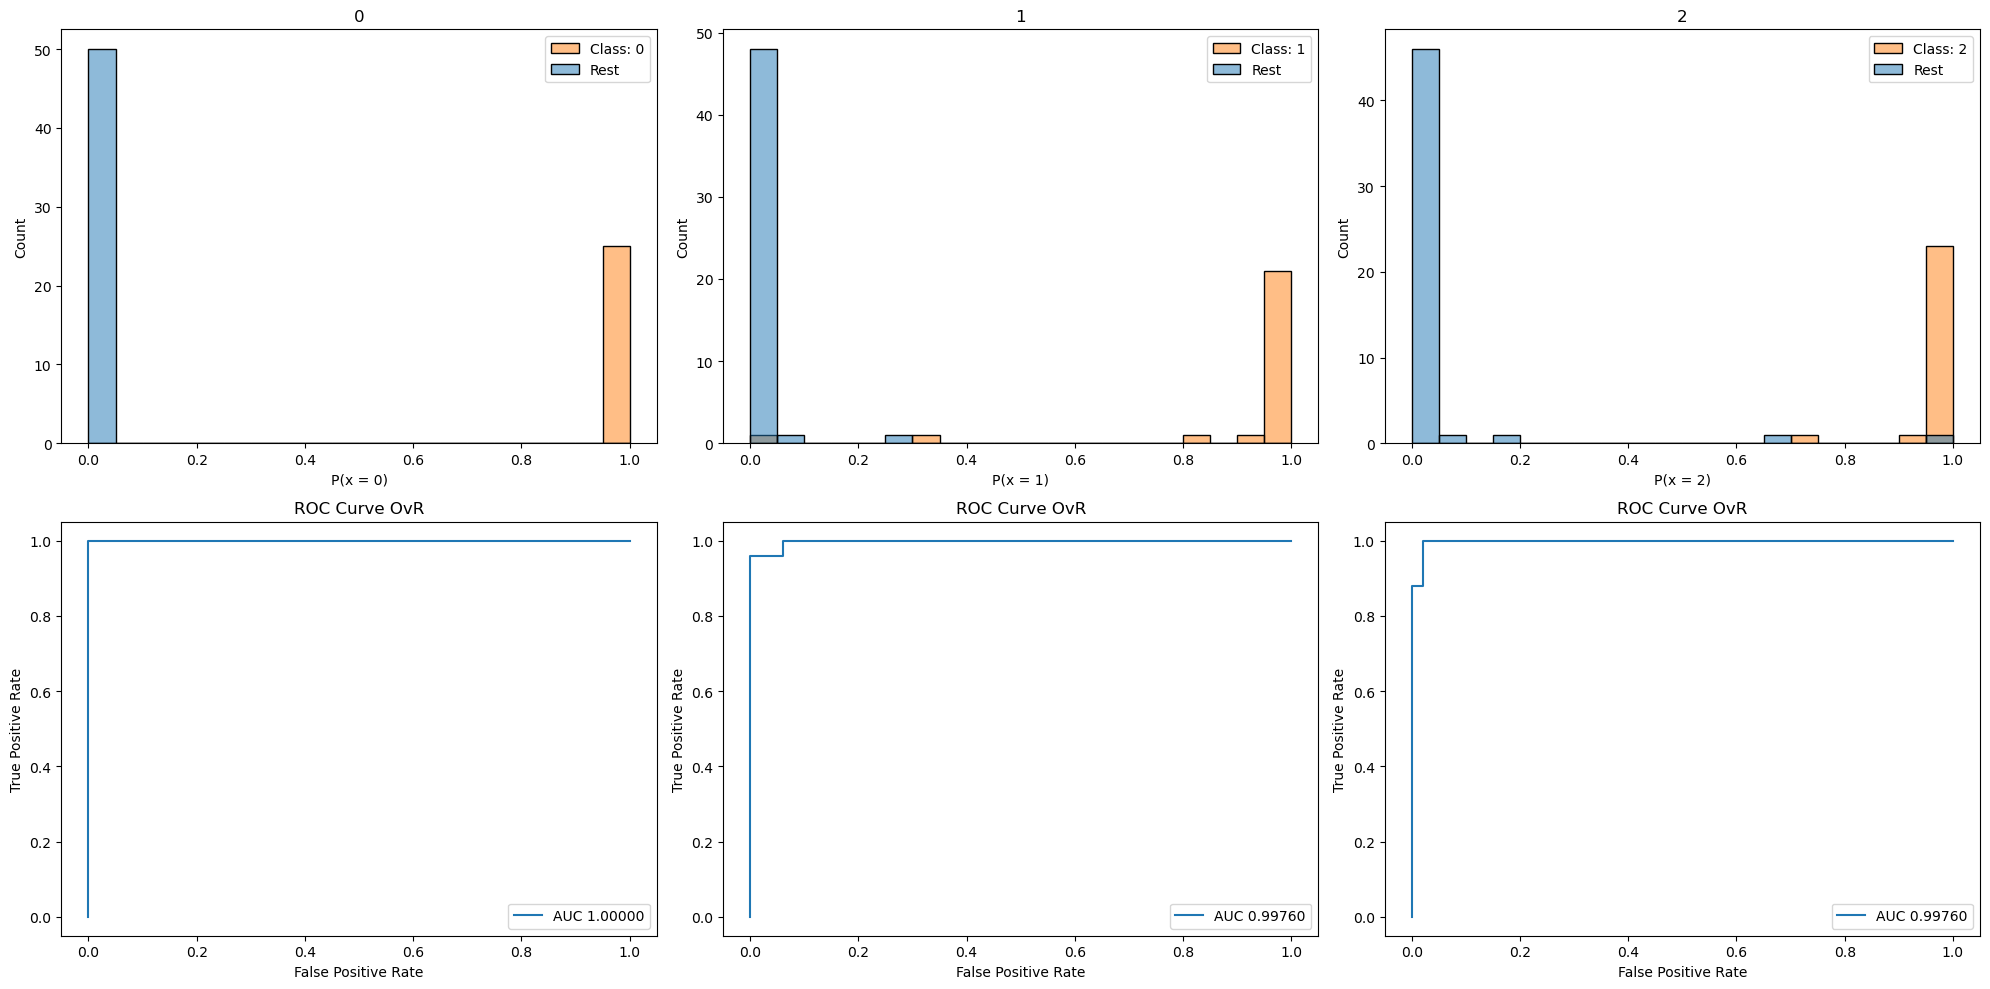

In [11]:
plot_roc_auc_multi_OvR(model = model_NB, figsize=(20,10))

In [12]:
def plot_roc_auc_multi_OvO(model, X_train=np.array(X_train), X_test=np.array(X_test), 
                       y_train=np.array(y_train), y_test=np.array(y_test),
                       figsize = (12, 8)
                      ):
    import itertools
    cl_len = len(classes)
    class_list = model.classes_
    classes_combinations = np.array(list(itertools.combinations(class_list, 2)))

    plt.figure(figsize = figsize)
    bins = [i/20 for i in range(20)] + [1]
    roc_auc_ovo = {}

    for i in range(len(classes_combinations)):
        # Комбинация классов
        comb = classes_combinations[i]
        c1 = comb[0]
        c2 = comb[1]
        c1_index = class_list[c1]
        title = str(c1) + " vs " + str(c2)

        # Подготовка построения графиков
        df_aux = pd.DataFrame(X_test).copy()
        df_aux['class'] = y_test
        df_aux['prob'] =  model.predict_proba(X_test)[:, c1_index]

        # Нарезка данных для только для двух классов
        df_aux = df_aux[(df_aux['class'] == c1) | (df_aux['class'] == c2)]
        df_aux['class'] = [1 if y == c1 else 0 for y in df_aux['class']]
        df_aux = df_aux.reset_index(drop = True)

        # Графики распределения вероятностей  One vs One
        ax = plt.subplot(2, cl_len, i+1)
        sns.histplot(x = "prob", data = df_aux, hue = 'class', color = 'b', ax = ax, bins = bins)
        ax.set_title(title)
        ax.legend([f"Class 1: {c1}", f"Class 0: {c2}"])
        ax.set_xlabel(f"P(x = {c1})")

        # Вычисления ROC AUC OvR
        roc_auc_ovr = roc_auc_score(df_aux['class'], df_aux['prob'])

        # Вычмсление координат ROC и построения кривой ROC
        ax_bottom = plt.subplot(2, cl_len, i+cl_len+1)
        fpr, tpr, _ = roc_curve(df_aux['class'], df_aux['prob'])
        ax_bottom.plot(fpr, tpr, label='AUC %.5f'%roc_auc_ovr)
        ax_bottom.set_title("ROC Curve OvO")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        ax_bottom.legend()

    plt.tight_layout()

In [13]:
plot_roc_auc_multi_OvO(model = model_NB, figsize=(20,10))

NameError: name 'classes' is not defined